# **FASTTEXT MODEL**

In [1]:
import data_processing as dp
import evaluation_metrics as em
import numpy as np
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

local_path = '../data/'

## I. Load Data and Create Train/Dev/Test Sets

#### Human sequences

In [2]:
human_sequences,_ = dp.load_FASTA(local_path+'human_sequences.fasta')
human_train_idx, human_valid_idx, human_test_idx, human_train_labels, \
    human_valid_labels, human_test_labels, human_GO_terms \
    = dp.load_test_sets(local_path+'human_annotations_temporal_holdout.mat')

# Create train, validation, and test sets from the full list of human proteins
human_train_sequences = [human_sequences[i] for i in human_train_idx]
human_valid_sequences = [human_sequences[i] for i in human_valid_idx]
human_test_sequences = [human_sequences[i] for i in human_test_idx]

# Convert corresponding labels for train, validation, and test sets from the full list of human proteins.
human_train_labels = torch.from_numpy(human_train_labels).type(torch.LongTensor)
human_valid_labels = torch.from_numpy(human_valid_labels).type(torch.LongTensor)
human_test_labels = torch.from_numpy(human_test_labels).type(torch.LongTensor)

# Create lengths for sequence representation averaging in FastText
human_train_lengths = dp.sequence_lengths(human_train_sequences)
human_valid_lengths = dp.sequence_lengths(human_valid_sequences)
human_test_lengths = dp.sequence_lengths(human_test_sequences)

# Convert protein sequence strings into long tensors where each int corresponds
# to one of 22 amino acids
human_train_tensors = dp.TransformAAsToTensor(human_train_sequences)
human_valid_tensors = dp.TransformAAsToTensor(human_valid_sequences)
human_test_tensors = dp.TransformAAsToTensor(human_test_sequences)

#### Yeast sequences

In [3]:
# Load yeast sequences and training data
yeast_sequences, yeast_protein_names = dp.load_FASTA(local_path+'yeast_sequences.fasta')
yeast_train_idx, yeast_valid_idx, yeast_test_idx, yeast_train_labels, yeast_valid_labels, \
    yeast_test_labels, yeast_GO_terms = dp.load_test_sets(local_path+'yeast_MF_temporal_holdout.mat')

# Create train, validation, and test sets from the full list of yeast proteins
yeast_train_sequences = [yeast_sequences[i] for i in yeast_train_idx]
yeast_valid_sequences = [yeast_sequences[i] for i in yeast_valid_idx]
yeast_test_sequences = [yeast_sequences[i] for i in yeast_test_idx]

# Convert labels for train, validation, and test sets to tensors.
yeast_train_labels = torch.from_numpy(yeast_train_labels).type(torch.LongTensor)
yeast_valid_labels = torch.from_numpy(yeast_valid_labels).type(torch.LongTensor)
yeast_test_labels = torch.from_numpy(yeast_test_labels).type(torch.LongTensor)

# Create lengths for sequence representation averaging in FastText
yeast_train_lengths = dp.sequence_lengths(yeast_train_sequences)
yeast_valid_lengths = dp.sequence_lengths(yeast_valid_sequences)
yeast_test_lengths = dp.sequence_lengths(yeast_test_sequences)

# Convert protein sequence strings into long tensors where each int corresponds
# to one of 22 amino acids
yeast_train_tensors = dp.TransformAAsToTensor(yeast_train_sequences)
yeast_valid_tensors = dp.TransformAAsToTensor(yeast_valid_sequences)
yeast_test_tensors = dp.TransformAAsToTensor(yeast_test_sequences)

## II. Build Model

### FastText Class

In [4]:
class FastText(nn.Module):
    """
    FastText model
    """
       
    def __init__(self, vocab_size, emb_dim, num_labels):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(FastText, self).__init__()

        self.num_labels = num_labels
        self.embed = nn.Embedding(vocab_size+1, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,num_labels)
        self.init_weights()
    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        data = data.type(torch.LongTensor)
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out = out / length.view(-1,1).float()
            
        out = self.linear(out)
        return nn.functional.sigmoid(out)
    
    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.linear]
        em_layer = [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)
                

### Early stop condition

In [5]:
def early_stop(val_loss_history, t=3, required_progress=0.001):
    """
    Stop the training if there is no non-trivial progress in k steps
    @param val_acc_history: a list contains all the historical validation acc
    @param required_progress: the next acc should be higher than the previous by 
        at least required_progress amount to be non-trivial
    @param t: number of training steps 
    @return: a boolean indicates if the model should earily stop
    """
    # TODO: add your code here
    
    cnt = 0 # initialize the count --> to store count of cases where difference in
                                    #  accuracy is less than required progress.
    
    if(len(val_loss_history) > 0): # if list has size > 0 
        for i in range(t): # start the loop
            index = len(val_loss_history) - (i+1) # start from the last term in list and move to the left
            if (index >= 1): # to check if index != 0 --> else we can't compare to previous value
                if ((val_loss_history[index-1] - val_loss_history[index]) < required_progress):
                    cnt += 1 # increase the count value
                else:
                    break # break if difference is greater 
    
    if(cnt != t): # if count is equal to t, return True
        return False
    else:
        return True

### Training Loop

In [6]:
def train_test(valid_sequences, valid_label, valid_length, num_epochs, optimizer, data_iter, model, training_length, method = 'GoTerm'):
    losses = []
    total_batches = int(training_length/ batch_size)
    validation_loss_history = []
    
    for epoch in range(1, num_epochs+1):
        stop_training = False
        for i, (train_data, train_labels, length_batch) in enumerate(data_iter):
            model.train()
            model.zero_grad()
            
            outputs = model(train_data, length_batch)

            loss = criterion(outputs, train_labels.float())
            losses.append(loss.data[0])
            loss.backward()
            optimizer.step()

            '''
            May want to re-consider whether we need to find validation metrics after each step.
            For FastText, not a major issue.
            '''
            model.eval()
            val_outputs = model(Variable(valid_sequences), Variable(valid_length))
            val_loss = criterion(val_outputs, Variable(valid_label).float()).data[0]
            validation_loss_history.append(val_loss)
            stop_training = early_stop(validation_loss_history)

            if stop_training:
                print("earily stop triggered")
                break
            
            if (i+1) % batch_size == 0:
                print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Validation Loss: {}'\
                      .format(epoch, num_epochs, i+1, total_batches, \
                              np.mean(losses)/(total_batches*epoch), val_loss))
        
        if stop_training == True:
            break

## III. Train and Evaluate Model

### Hyperparameters 

In [7]:
learning_rate = 0.001
vocab_size = 26 # number words in the vocabulary base
emb_dim = 20 # dimension for n-gram embedding
num_epochs = 500 # number epoch to train
batch_size = 20

### Human Results

In [8]:
data_size = len(human_train_tensors)
num_labels = human_GO_terms.shape[0] #147

model = FastText(vocab_size, emb_dim, num_labels)
criterion = nn.MultiLabelSoftMarginLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

Epoch: [1/500], Step: [20/487], Train loss: 0.0018472558419072897, Validation Loss: 0.9059403538703918
Epoch: [1/500], Step: [40/487], Train loss: 0.001739980066214254, Validation Loss: 0.8711393475532532
earily stop triggered
AUC: 0.55
AUPR: 0.02


/Users/Brenton/Documents/Capstone/Beyond-Google/evaluation_metrics.py:57: RuntimeWarning: invalid value encountered in true_divide
  FScores = 2*precision*recall/(precision+recall)


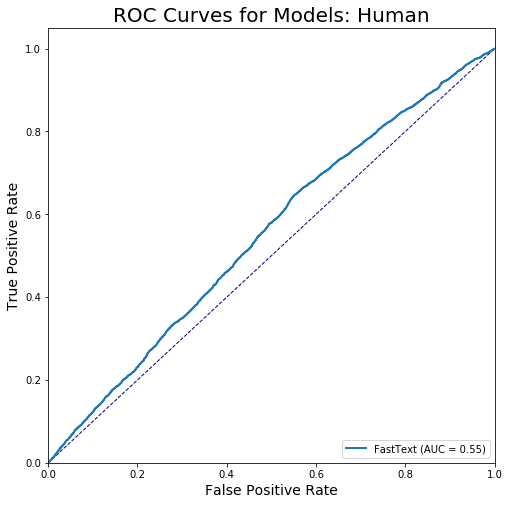

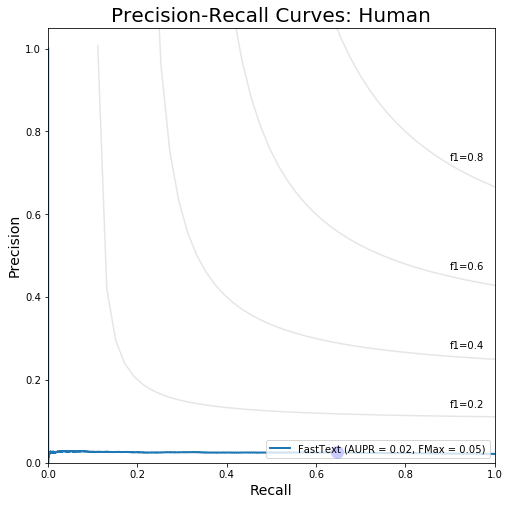

In [9]:
data_iter = dp.batch_iter(batch_size, human_train_tensors, human_train_labels, human_train_lengths)

# Model Training
train_test(human_valid_tensors, human_valid_labels, human_valid_lengths, \
           num_epochs, optimizer, data_iter, model, data_size, method = 'GoTerm') 


test_set_predictions = model(Variable(human_test_tensors), Variable(human_test_lengths))

predictions = test_set_predictions.data.numpy()
actual = human_test_labels.numpy()
AUC = em.calculate_AUC(predictions, actual)[0]
AUPR = em.calculate_AUPR(predictions, actual)
print('AUC: %0.2f' % AUC)
print('AUPR: %0.2f' % AUPR)
em.plot_AUC_curve(predictions, actual, 'FastText', 'Human')
em.plot_AUPR_curve(predictions, actual, 'FastText', 'Human')

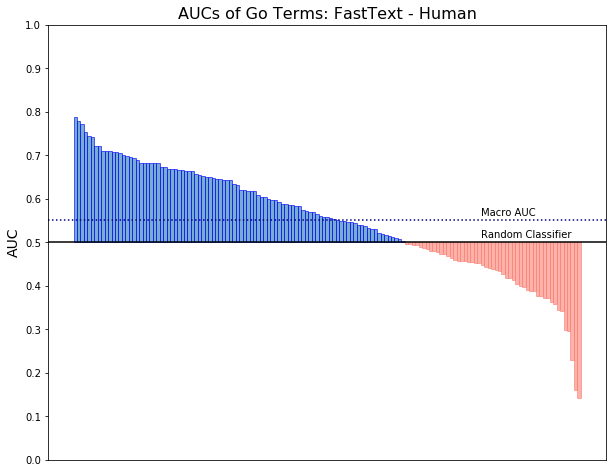

In [10]:
AUCs = em.find_GoTerm_aucs(predictions, actual)
em.plot_GoTerm_Bars(AUCs, 'FastText', 'Human', 'AUC')

### Yeast Results

In [11]:
data_size = len(yeast_train_sequences) #3447
num_labels = yeast_GO_terms.shape[0] #26

model = FastText(vocab_size, emb_dim, num_labels)
criterion = nn.MultiLabelSoftMarginLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

Epoch: [1/500], Step: [20/172], Train loss: 0.005335621327854866, Validation Loss: 0.8762041330337524
Epoch: [1/500], Step: [40/172], Train loss: 0.005212068930268287, Validation Loss: 0.84934002161026
Epoch: [1/500], Step: [60/172], Train loss: 0.00511277886901715, Validation Loss: 0.8267854452133179
earily stop triggered
AUC: 0.56
AUPR: 0.12


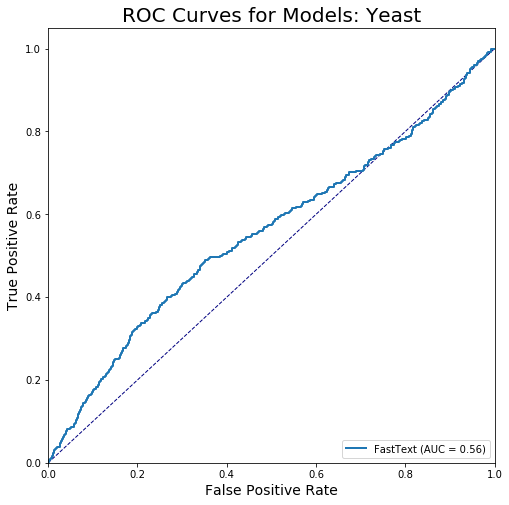

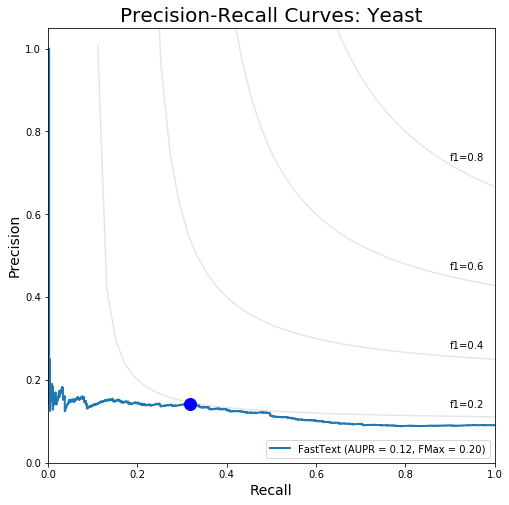

In [12]:
data_iter = dp.batch_iter(batch_size, yeast_train_tensors, yeast_train_labels, yeast_train_lengths)

# Model Training
train_test(yeast_valid_tensors, yeast_valid_labels, yeast_valid_lengths, \
           num_epochs, optimizer, data_iter, model, data_size, method = 'GoTerm')

test_set_predictions = model(Variable(yeast_test_tensors), Variable(yeast_test_lengths))

predictions = test_set_predictions.data.numpy()
actual = yeast_test_labels.numpy()
AUC = em.calculate_AUC(predictions, actual)[0]
AUPR = em.calculate_AUPR(predictions, actual)
print('AUC: %0.2f' % AUC)
print('AUPR: %0.2f' % AUPR)
em.plot_AUC_curve(predictions, actual, 'FastText', 'Yeast')
em.plot_AUPR_curve(predictions, actual, 'FastText', 'Yeast')

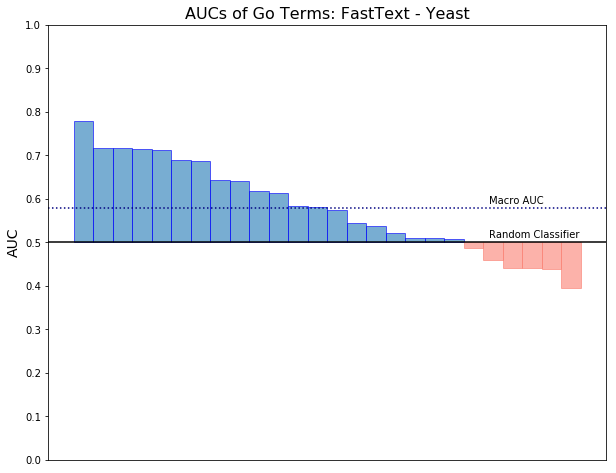

In [13]:
AUCs = em.find_GoTerm_aucs(predictions, actual)
em.plot_GoTerm_Bars(AUCs, 'FastText', 'Yeast', 'AUC')